# Trader Performance vs Market Sentiment — Primetrade.ai Intern Assignment

## Notebook 1: Data Preparation (Part A) + Analysis (Part B)

**Datasets:** `fear_greed_index.csv` · `historical_data.csv`  
**Objective:** Discover how Bitcoin market sentiment (Fear/Greed) relates to Hyperliquid trader behavior and profitability.

---

## 0. Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid', palette='muted')
plt.rcParams['figure.dpi'] = 110

FEAR_COLOR  = '#e74c3c'
GREED_COLOR = '#2ecc71'
palette = {'Fear': FEAR_COLOR, 'Greed': GREED_COLOR}

print('Libraries ready ✓')

Libraries ready ✓


---
## Part A — Data Preparation

### A1. Load Both Datasets

In [2]:
fg = pd.read_csv('fear_greed_index.csv')
print('Fear/Greed Index — shape:', fg.shape)
fg.head()

Fear/Greed Index — shape: (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [3]:
hd = pd.read_csv('historical_data.csv')
print('Historical Trader Data — shape:', hd.shape)
hd.head()

Historical Trader Data — shape: (211224, 16)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


### A2. Documentation — Rows, Columns, Missing Values, Duplicates

In [4]:
def dataset_summary(df, name):
    print('=' * 60)
    print(f'Dataset: {name}')
    print(f'  Rows: {df.shape[0]:,}  |  Columns: {df.shape[1]}')
    print(f'  Duplicate rows: {df.duplicated().sum():,}')
    miss  = df.isnull().sum()
    miss_pct = (miss / len(df) * 100).round(2)
    summary = pd.DataFrame({'Missing': miss, 'Missing%': miss_pct, 'Dtype': df.dtypes})
    print(summary.to_string())
    print()

dataset_summary(fg, 'Fear/Greed Index')
dataset_summary(hd, 'Historical Trader Data (Hyperliquid)')

Dataset: Fear/Greed Index
  Rows: 2,644  |  Columns: 4
  Duplicate rows: 0
                Missing  Missing%   Dtype
timestamp             0       0.0   int64
value                 0       0.0   int64
classification        0       0.0  object
date                  0       0.0  object

Dataset: Historical Trader Data (Hyperliquid)
  Rows: 211,224  |  Columns: 16
  Duplicate rows: 0
                  Missing  Missing%    Dtype
Account                 0       0.0   object
Coin                    0       0.0   object
Execution Price         0       0.0  float64
Size Tokens             0       0.0  float64
Size USD                0       0.0  float64
Side                    0       0.0   object
Timestamp IST           0       0.0   object
Start Position          0       0.0  float64
Direction               0       0.0   object
Closed PnL              0       0.0  float64
Transaction Hash        0       0.0   object
Order ID                0       0.0    int64
Crossed                 0      

### A3. Timestamp Conversion & Date Alignment

In [5]:
# ---- Fear/Greed ----
fg['date'] = pd.to_datetime(fg['date'])
fg = fg.drop_duplicates('date').sort_values('date').reset_index(drop=True)
fg['sentiment_binary'] = fg['classification'].apply(
    lambda x: 'Fear' if 'Fear' in str(x) else 'Greed'
)
print('FG date range:', fg['date'].min().date(), '→', fg['date'].max().date())
print(fg['classification'].value_counts())

FG date range: 2018-02-01 → 2025-05-02
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


In [6]:
# ---- Detect timestamp column in trader data ----
time_col = None
for c in hd.columns:
    if any(k in c.lower() for k in ['time', 'date', 'ist']):
        time_col = c
        break
print('Time column detected:', time_col)
print('Sample:', hd[time_col].head(3).tolist())

hd['trade_dt'] = pd.to_datetime(hd[time_col], errors='coerce', utc=True)
hd['date']     = pd.to_datetime(
    hd['trade_dt'].dt.normalize().dt.tz_localize(None).dt.date
)
print('\nTrader data date range:', hd['date'].min().date(), '→', hd['date'].max().date())
print('Null datetimes:', hd['trade_dt'].isna().sum())

Time column detected: Timestamp IST
Sample: ['02-12-2024 22:50', '02-12-2024 22:50', '02-12-2024 22:50']

Trader data date range: 2023-01-05 → 2025-12-04
Null datetimes: 131999


### A4. Column Detection & Metric Creation

In [7]:
# --- Column detection (handles naming variations) ---
col_map = {c.lower(): c for c in hd.columns}

def find_col(keywords):
    for kw in keywords:
        for k, v in col_map.items():
            if kw in k:
                return v
    return None

ACCOUNT  = find_col(['account', 'wallet', 'user'])
PNL      = find_col(['closedpnl', 'pnl', 'realized'])
SIZE_USD = find_col(['size usd', 'sizeusd', 'size_usd', 'notional'])
SIDE     = find_col(['side', 'direction'])
LEV      = find_col(['leverage'])

if SIZE_USD is None:
    SIZE_USD = find_col(['size token', 'sizetoken', 'quantity'])

print(f'Account : {ACCOUNT}')
print(f'PnL     : {PNL}')
print(f'Size USD: {SIZE_USD}')
print(f'Side    : {SIDE}')
print(f'Leverage: {LEV}')

Account : Account
PnL     : Closed PnL
Size USD: Size USD
Side    : Side
Leverage: None


In [8]:
# --- Numeric conversion ---
for col in [PNL, SIZE_USD, LEV]:
    if col is not None:
        hd[col] = pd.to_numeric(
            hd[col].astype(str).str.replace(',', '').str.strip(),
            errors='coerce'
        )

# Derived columns
if PNL  is not None: hd['is_win']  = hd[PNL]  > 0
if SIDE is not None:
    hd['is_long'] = hd[SIDE].astype(str).str.upper().str.contains('BUY|LONG', na=False)

print('PnL sample stats:')
if PNL: print(hd[PNL].describe())

PnL sample stats:
count    211224.000000
mean         48.749001
std         919.164828
min     -117990.104100
25%           0.000000
50%           0.000000
75%           5.792797
max      135329.090100
Name: Closed PnL, dtype: float64


In [9]:
# --- Account-level daily aggregates ---
# Build aggregation dict only for columns that exist
grp = hd.groupby([ACCOUNT, 'date'])

daily_parts = []

# Always include account + date as index values
base = grp.size().rename('trade_count').reset_index()
daily_parts.append(base)

if PNL:
    daily_parts.append(grp[PNL].sum().rename('daily_pnl').reset_index())
    daily_parts.append(grp['is_win'].sum().rename('win_count').reset_index())

if SIZE_USD:
    daily_parts.append(grp[SIZE_USD].mean().rename('avg_size_usd').reset_index())

if LEV:
    daily_parts.append(grp[LEV].mean().rename('avg_leverage').reset_index())

if SIDE:
    daily_parts.append(grp['is_long'].sum().rename('long_count').reset_index())

# Merge all parts on [ACCOUNT, date]
daily_acct = daily_parts[0]
for part in daily_parts[1:]:
    daily_acct = daily_acct.merge(part, on=[ACCOUNT, 'date'], how='left')

if 'win_count' in daily_acct.columns:
    daily_acct['win_rate']   = daily_acct['win_count'] / daily_acct['trade_count'].replace(0, np.nan)
if 'long_count' in daily_acct.columns:
    daily_acct['long_ratio'] = daily_acct['long_count'] / daily_acct['trade_count'].replace(0, np.nan)

print('Daily account shape:', daily_acct.shape)
daily_acct.head()

Daily account shape: (907, 9)


,Account,date,trade_count,daily_pnl,win_count,avg_size_usd,long_count,win_rate,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-06-12,33,-175611.000056,0,36736.362424,33,0.000000,1.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,177,0.000000,0,5089.718249,0,0.000000,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-03,45,9482.221441,36,2985.797556,36,0.800000,0.800000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-02,10,76710.000000,9,185847.000000,9,0.900000,0.900000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-03-02,839,101011.685664,256,23593.019857,350,0.305125,0.417163


In [10]:
# --- Market-level daily aggregates ---
mkt_grp = hd.groupby('date')
mkt_parts = [mkt_grp.size().rename('total_trades').reset_index()]

if PNL:
    mkt_parts.append(mkt_grp[PNL].sum().rename('total_daily_pnl').reset_index())
    mkt_parts.append(mkt_grp['is_win'].mean().rename('avg_win_rate').reset_index())
if LEV:
    mkt_parts.append(mkt_grp[LEV].mean().rename('avg_leverage').reset_index())
if SIZE_USD:
    mkt_parts.append(mkt_grp[SIZE_USD].mean().rename('avg_size_usd').reset_index())
if SIDE:
    mkt_parts.append(mkt_grp['is_long'].mean().rename('long_ratio').reset_index())
mkt_parts.append(mkt_grp[ACCOUNT].nunique().rename('active_traders').reset_index())

market_daily = mkt_parts[0]
for part in mkt_parts[1:]:
    market_daily = market_daily.merge(part, on='date', how='left')

print('Market daily shape:', market_daily.shape)
market_daily.head()

Market daily shape: (188, 7)


,date,total_trades,total_daily_pnl,avg_win_rate,avg_size_usd,long_ratio,active_traders
0,2023-01-05,3,0.000000,0.000000,159.000000,1.000000,1
1,2023-05-12,9,0.000000,0.000000,5556.203333,0.777778,1
2,2024-01-01,18,-129.531460,0.055556,14679.973889,0.555556,1
3,2024-01-02,6,0.000000,0.000000,334.696667,1.000000,1
4,2024-01-03,137,8244.241409,0.934307,3452.370073,0.270073,1


### A5. Merge by Date

In [11]:
merged = market_daily.merge(
    fg[['date', 'value', 'classification', 'sentiment_binary']],
    on='date', how='inner'
)

daily_acct_sent = daily_acct.merge(
    fg[['date', 'value', 'classification', 'sentiment_binary']],
    on='date', how='inner'
)

print(f'Merged market-level : {merged.shape}  ({merged["sentiment_binary"].value_counts().to_dict()})')
print(f'Acct-level with sent: {daily_acct_sent.shape}')
merged.head()

Merged market-level : (158, 10)  ({'Greed': 115, 'Fear': 43})
Acct-level with sent: (530, 12)


,date,total_trades,total_daily_pnl,avg_win_rate,avg_size_usd,long_ratio,active_traders,value,classification,sentiment_binary
0,2023-01-05,3,0.000000,0.000000,159.000000,1.000000,1,29,Fear,Fear
1,2023-05-12,9,0.000000,0.000000,5556.203333,0.777778,1,49,Neutral,Greed
2,2024-01-01,18,-129.531460,0.055556,14679.973889,0.555556,1,65,Greed,Greed
3,2024-01-02,6,0.000000,0.000000,334.696667,1.000000,1,71,Greed,Greed
4,2024-01-03,137,8244.241409,0.934307,3452.370073,0.270073,1,70,Greed,Greed


---
## Part B — Analysis

### B1. Performance (PnL, Win Rate, Drawdown) — Fear vs Greed

In [12]:
# Statistical comparison
fear_df  = merged[merged['sentiment_binary'] == 'Fear']
greed_df = merged[merged['sentiment_binary'] == 'Greed']

test_cols = [c for c in ['total_daily_pnl', 'avg_win_rate', 'avg_leverage', 'long_ratio', 'total_trades']
             if c in merged.columns]

print('Mann-Whitney U Tests (Fear vs Greed):')
print('-'*72)
rows = []
for col in test_cols:
    a, b = fear_df[col].dropna(), greed_df[col].dropna()
    if len(a) > 5 and len(b) > 5:
        _, p = stats.mannwhitneyu(a, b, alternative='two-sided')
        rows.append({'Metric': col, 'Fear Mean': round(a.mean(), 4),
                     'Greed Mean': round(b.mean(), 4), 'p-value': round(p, 4),
                     'Significant?': '✓ YES' if p < 0.05 else '✗ no'})
pd.DataFrame(rows).set_index('Metric')

Mann-Whitney U Tests (Fear vs Greed):
------------------------------------------------------------------------


,Fear Mean,Greed Mean,p-value,Significant?
Metric,,,,
total_daily_pnl,41479.6632,16010.2865,0.4522,✗ no
avg_win_rate,0.3424,0.3359,0.9126,✗ no
long_ratio,0.5165,0.5026,0.8511,✗ no
total_trades,376.6279,171.0348,0.2077,✗ no


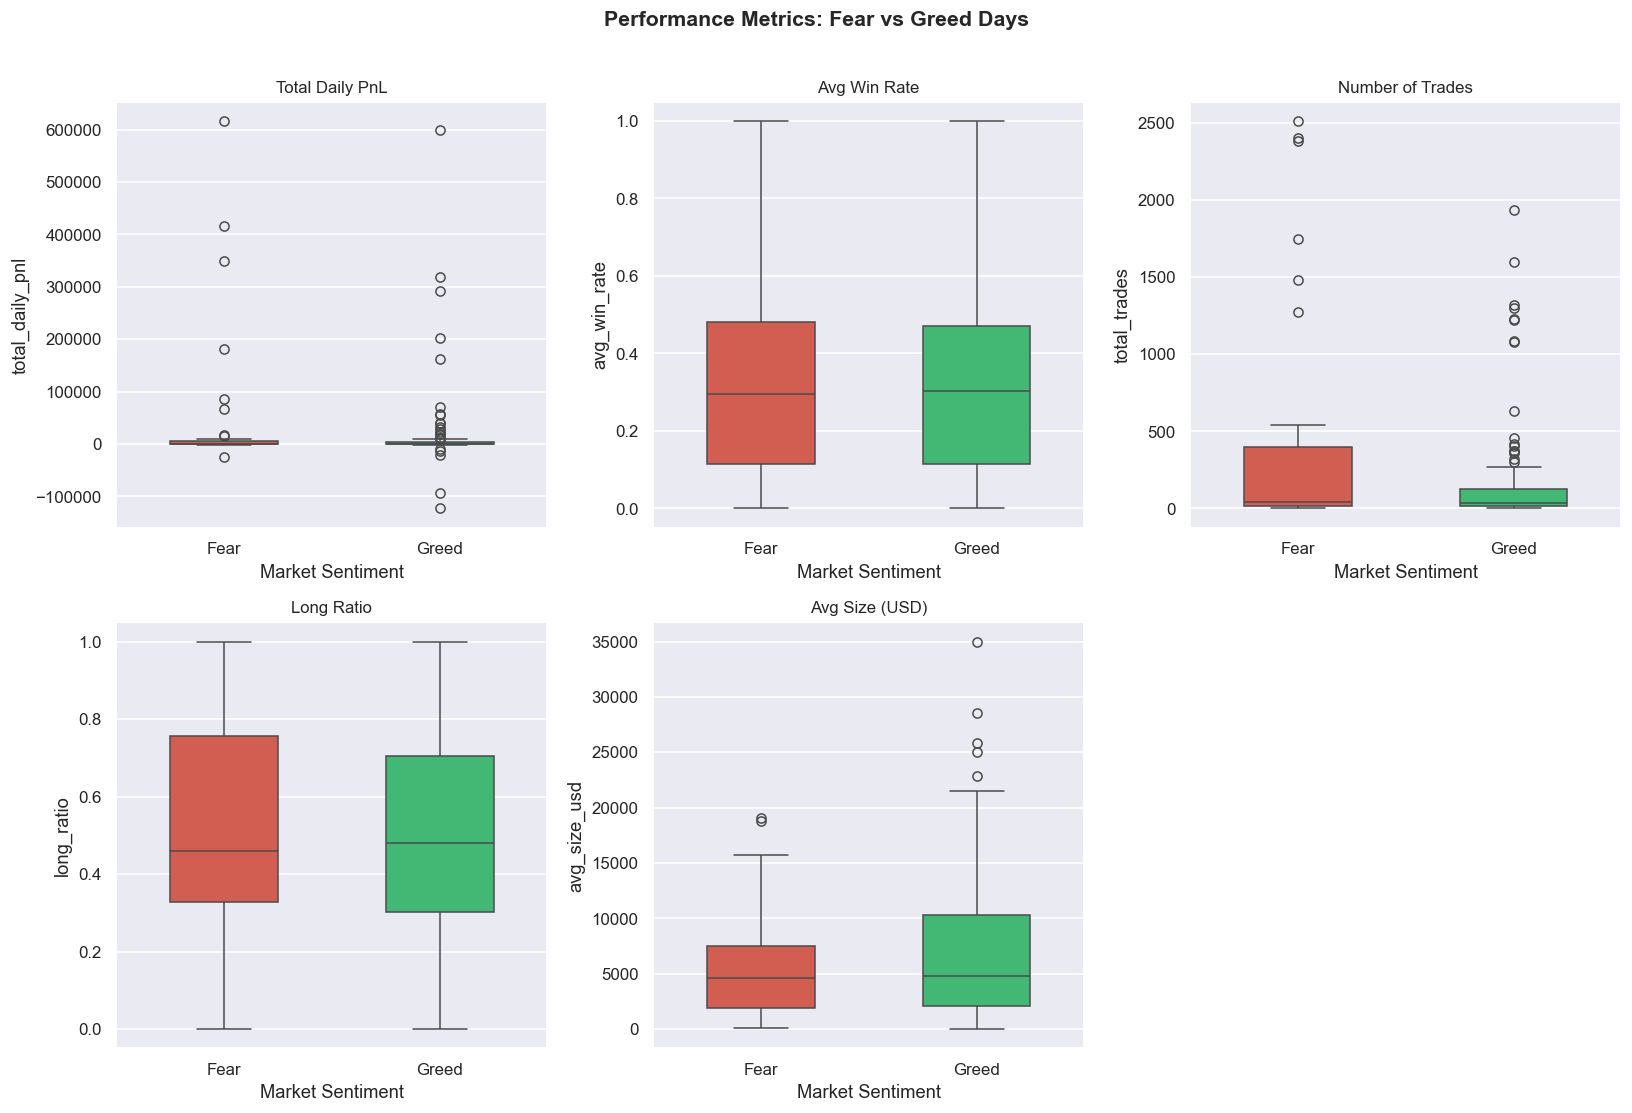

Saved ✓


In [13]:
# Box-plot comparison
plot_cols = [c for c in ['total_daily_pnl', 'avg_win_rate', 'avg_leverage',
                          'total_trades', 'long_ratio', 'avg_size_usd']
             if c in merged.columns]
labels    = {'total_daily_pnl': 'Total Daily PnL',
             'avg_win_rate': 'Avg Win Rate',
             'avg_leverage': 'Avg Leverage',
             'total_trades': 'Number of Trades',
             'long_ratio': 'Long Ratio',
             'avg_size_usd': 'Avg Size (USD)'}

n = len(plot_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

for i, col in enumerate(plot_cols):
    sns.boxplot(data=merged, x='sentiment_binary', y=col, palette=palette,
                order=['Fear', 'Greed'], ax=axes[i], width=0.5)
    axes[i].set_title(labels.get(col, col), fontsize=11)
    axes[i].set_xlabel('Market Sentiment')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Performance Metrics: Fear vs Greed Days', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('chart_b1_performance.png', bbox_inches='tight')
plt.show()
print('Saved ✓')

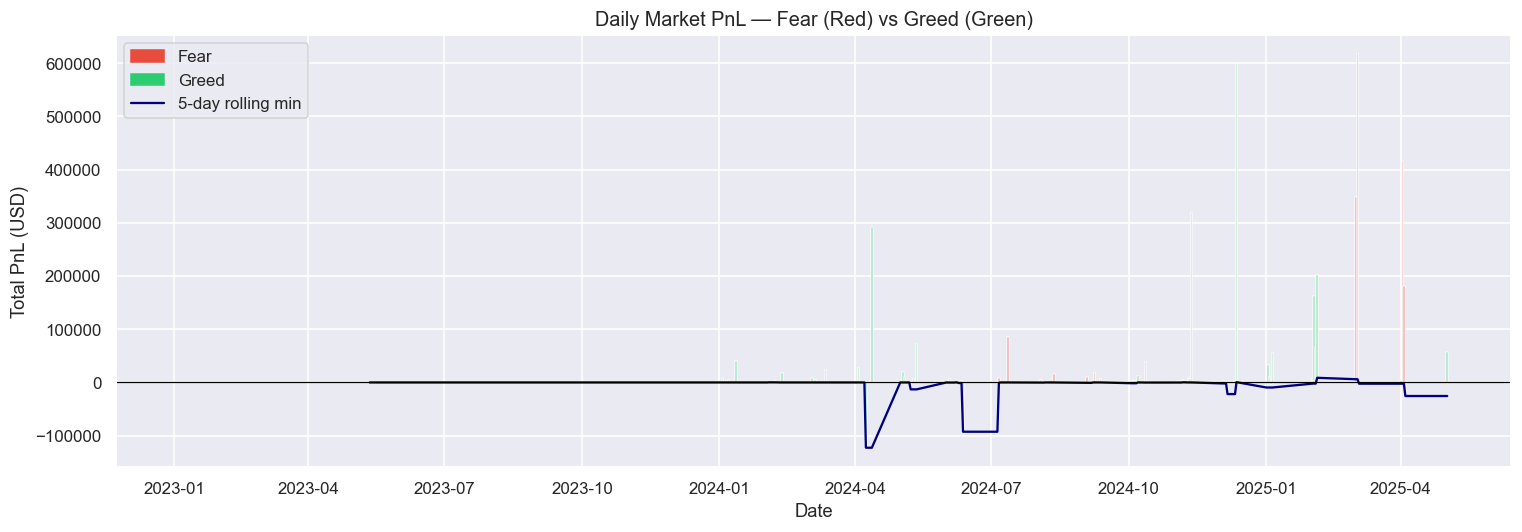

Saved ✓


In [14]:
# PnL over time with sentiment coloring + 5-day rolling min as drawdown proxy
ms = merged.sort_values('date').copy()
if 'total_daily_pnl' in ms.columns:
    ms['rolling_min'] = ms['total_daily_pnl'].rolling(5, min_periods=2).min()
    fig, ax = plt.subplots(figsize=(14, 5))
    bar_colors = ms['sentiment_binary'].map(palette)
    ax.bar(ms['date'], ms['total_daily_pnl'], color=bar_colors, alpha=0.7, width=1)
    ax.plot(ms['date'], ms['rolling_min'], color='navy', lw=1.5, label='5-day rolling min (drawdown proxy)')
    ax.axhline(0, color='black', lw=0.8)
    ax.set_title('Daily Market PnL — Fear (Red) vs Greed (Green)', fontsize=13)
    ax.set_xlabel('Date'); ax.set_ylabel('Total PnL (USD)')
    from matplotlib.patches import Patch
    ax.legend(handles=[Patch(color=FEAR_COLOR, label='Fear'), Patch(color=GREED_COLOR, label='Greed'),
                        plt.Line2D([0],[0], color='navy', label='5-day rolling min')])
    plt.tight_layout()
    plt.savefig('chart_b1_pnl_timeline.png', bbox_inches='tight')
    plt.show()
    print('Saved ✓')

### B2. Behavioral Changes Based on Sentiment

In [15]:
# Account-level behavior by sentiment
behav_cols = [c for c in ['win_rate', 'avg_leverage', 'long_ratio', 'trade_count', 'avg_size_usd']
              if c in daily_acct_sent.columns]

bhv = daily_acct_sent.groupby('sentiment_binary')[behav_cols].mean().T
bhv['Δ (Greed - Fear)'] = bhv.get('Greed', 0) - bhv.get('Fear', 0)
bhv['Δ%'] = (bhv['Δ (Greed - Fear)'] / bhv.get('Fear', 1) * 100).round(2)
print('Behavior shift: Fear → Greed')
bhv.round(4)

Behavior shift: Fear → Greed


sentiment_binary,Fear,Greed,Δ (Greed - Fear),Δ%
win_rate,0.3193,0.3430,0.0238,7.45
long_ratio,0.5595,0.5070,-0.0525,-9.38
trade_count,85.2368,57.8500,-27.3868,-32.13
avg_size_usd,7539.7528,6891.3011,-648.4518,-8.60


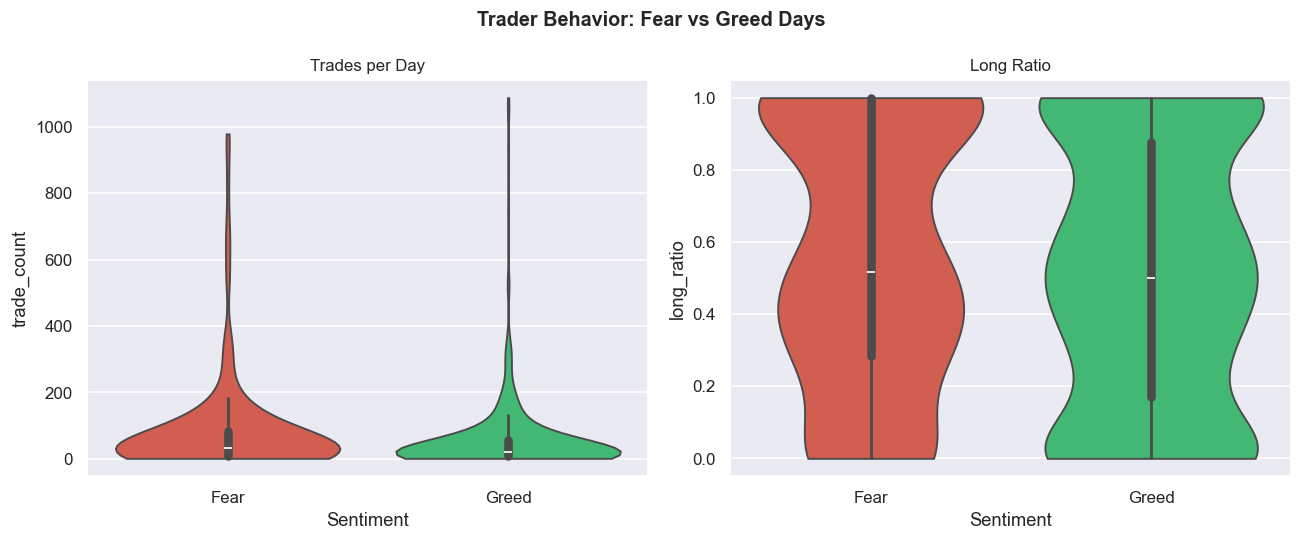

Saved ✓


In [16]:
violin_cols = [c for c in ['avg_leverage', 'trade_count', 'long_ratio']
               if c in daily_acct_sent.columns]

fig, axes = plt.subplots(1, len(violin_cols), figsize=(5 * len(violin_cols) + 2, 5))
fig.suptitle('Trader Behavior: Fear vs Greed Days', fontsize=13, fontweight='bold')

vlabels = {'avg_leverage': 'Average Leverage', 'trade_count': 'Trades per Day', 'long_ratio': 'Long Ratio'}
axes = [axes] if len(violin_cols) == 1 else list(axes)

for ax, col in zip(axes, violin_cols):
    sns.violinplot(data=daily_acct_sent, x='sentiment_binary', y=col,
                   palette=palette, order=['Fear', 'Greed'], ax=ax, cut=0)
    ax.set_title(vlabels.get(col, col), fontsize=11)
    ax.set_xlabel('Sentiment')

plt.tight_layout()
plt.savefig('chart_b2_behavior.png', bbox_inches='tight')
plt.show()
print('Saved ✓')

### B3. Trader Segmentation

In [17]:
# Compute lifetime stats per account
acct_grp = hd.groupby(ACCOUNT)

lifetime_parts = []
if PNL:
    lifetime_parts.append(acct_grp[PNL].sum().rename('total_pnl'))
    lifetime_parts.append(acct_grp[PNL].count().rename('trade_count'))
    lifetime_parts.append(acct_grp['is_win'].mean().rename('win_rate'))
if LEV:
    lifetime_parts.append(acct_grp[LEV].mean().rename('avg_leverage'))
if SIZE_USD:
    lifetime_parts.append(acct_grp[SIZE_USD].mean().rename('avg_size_usd'))
if SIDE:
    lifetime_parts.append(acct_grp['is_long'].mean().rename('long_ratio'))

acct_life = pd.concat(lifetime_parts, axis=1).reset_index()
acct_life.columns = [ACCOUNT] + [s.name for s in lifetime_parts]

if 'total_pnl' in acct_life.columns:
    acct_life['pnl_per_trade'] = acct_life['total_pnl'] / acct_life['trade_count'].replace(0, np.nan)

# Daily PnL std (consistency proxy)
if 'daily_pnl' in daily_acct.columns:
    pnl_std = daily_acct.groupby(ACCOUNT)['daily_pnl'].std().rename('pnl_std')
    acct_life = acct_life.merge(pnl_std, on=ACCOUNT, how='left')

print('Account lifetime shape:', acct_life.shape)
acct_life.describe().T.round(3)

Account lifetime shape: (32, 8)


,count,mean,std,min,25%,50%,75%,max
total_pnl,32.0,321779.967,494827.630,-167621.125,46893.243,117655.079,406394.096,2143382.598
trade_count,32.0,6600.750,8250.374,332.000,1381.750,3699.000,8862.500,40184.000
win_rate,32.0,0.403,0.108,0.235,0.330,0.392,0.453,0.811
avg_size_usd,32.0,6007.929,7281.059,507.627,2011.070,3327.972,7375.525,34396.580
long_ratio,32.0,0.463,0.104,0.223,0.418,0.462,0.514,0.689
pnl_per_trade,32.0,97.686,134.918,-38.287,8.871,41.110,148.009,520.902
pnl_std,32.0,22435.925,38332.668,353.511,3515.120,7412.489,24496.340,195394.370


In [18]:
# --- Segment 1: High vs Low Leverage ---
display_cols = [c for c in ['total_pnl', 'win_rate', 'trade_count'] if c in acct_life.columns]

if 'avg_leverage' in acct_life.columns:
    lev_med = acct_life['avg_leverage'].median()
    acct_life['leverage_seg'] = acct_life['avg_leverage'].apply(
        lambda x: 'High Leverage' if x >= lev_med else 'Low Leverage'
    )
    print(f'Seg 1 — Leverage median: {lev_med:.2f}×')
    print(acct_life.groupby('leverage_seg')[display_cols].mean().round(4))

# --- Segment 2: Frequent vs Infrequent ---
if 'trade_count' in acct_life.columns:
    freq_thr = acct_life['trade_count'].quantile(0.75)
    acct_life['freq_seg'] = acct_life['trade_count'].apply(
        lambda x: 'Frequent' if x >= freq_thr else 'Infrequent'
    )
    print(f'\nSeg 2 — Freq threshold (75th pct): {freq_thr:.0f} trades')
    print(acct_life.groupby('freq_seg')[display_cols].mean().round(4))

# --- Segment 3: Consistent Winners vs Inconsistent ---
if 'win_rate' in acct_life.columns:
    WIN_THRESH = 0.55
    acct_life['consistency_seg'] = acct_life['win_rate'].apply(
        lambda x: 'Consistent Winner' if x >= WIN_THRESH else 'Inconsistent'
    )
    print(f'\nSeg 3 — Win rate threshold: {WIN_THRESH}')
    print(acct_life.groupby('consistency_seg')[display_cols].mean().round(4))



Seg 2 — Freq threshold (75th pct): 8862 trades
              total_pnl  win_rate  trade_count
freq_seg                                      
Frequent    677728.7022    0.4364      17769.0
Infrequent  203130.3886    0.3919       2878.0

Seg 3 — Win rate threshold: 0.55
                     total_pnl  win_rate  trade_count
consistency_seg                                      
Consistent Winner  225970.9455    0.6920    5155.0000
Inconsistent       328167.2351    0.3838    6697.1333


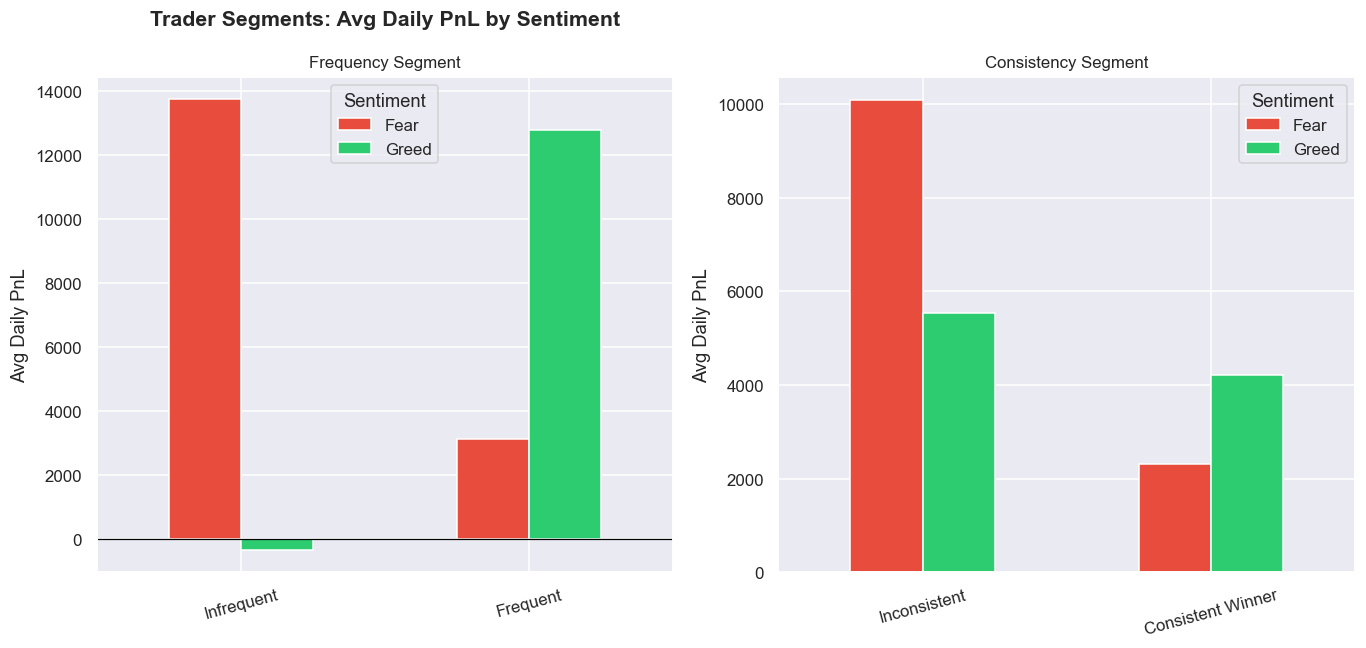

Saved ✓


In [19]:
# Merge segments with sentiment data
seg_cols = [ACCOUNT] + [c for c in ['leverage_seg', 'freq_seg', 'consistency_seg'] if c in acct_life.columns]
seg_sent = daily_acct_sent.merge(acct_life[seg_cols], on=ACCOUNT, how='inner')

seg_info = [
    ('leverage_seg',     ['Low Leverage', 'High Leverage'],       'Leverage Segment'),
    ('freq_seg',         ['Infrequent', 'Frequent'],              'Frequency Segment'),
    ('consistency_seg',  ['Inconsistent', 'Consistent Winner'],   'Consistency Segment'),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Trader Segments: Avg Daily PnL by Sentiment', fontsize=14, fontweight='bold')

for ax, (seg_col, order, title) in zip(axes, seg_info):
    if seg_col not in seg_sent.columns or 'daily_pnl' not in seg_sent.columns:
        ax.set_visible(False); continue
    pivot = seg_sent.groupby([seg_col, 'sentiment_binary'])['daily_pnl'].mean().unstack()
    available_order = [o for o in order if o in pivot.index]
    pivot.loc[available_order].plot(kind='bar', ax=ax, color=['#e74c3c', '#2ecc71'], edgecolor='white')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel(''); ax.set_ylabel('Avg Daily PnL')
    ax.axhline(0, color='black', lw=0.8)
    ax.tick_params(axis='x', rotation=15)
    ax.legend(title='Sentiment')

plt.tight_layout()
plt.savefig('chart_b3_segment_pnl.png', bbox_inches='tight')
plt.show()
print('Saved ✓')

### B4. Insights (≥3) with Charts

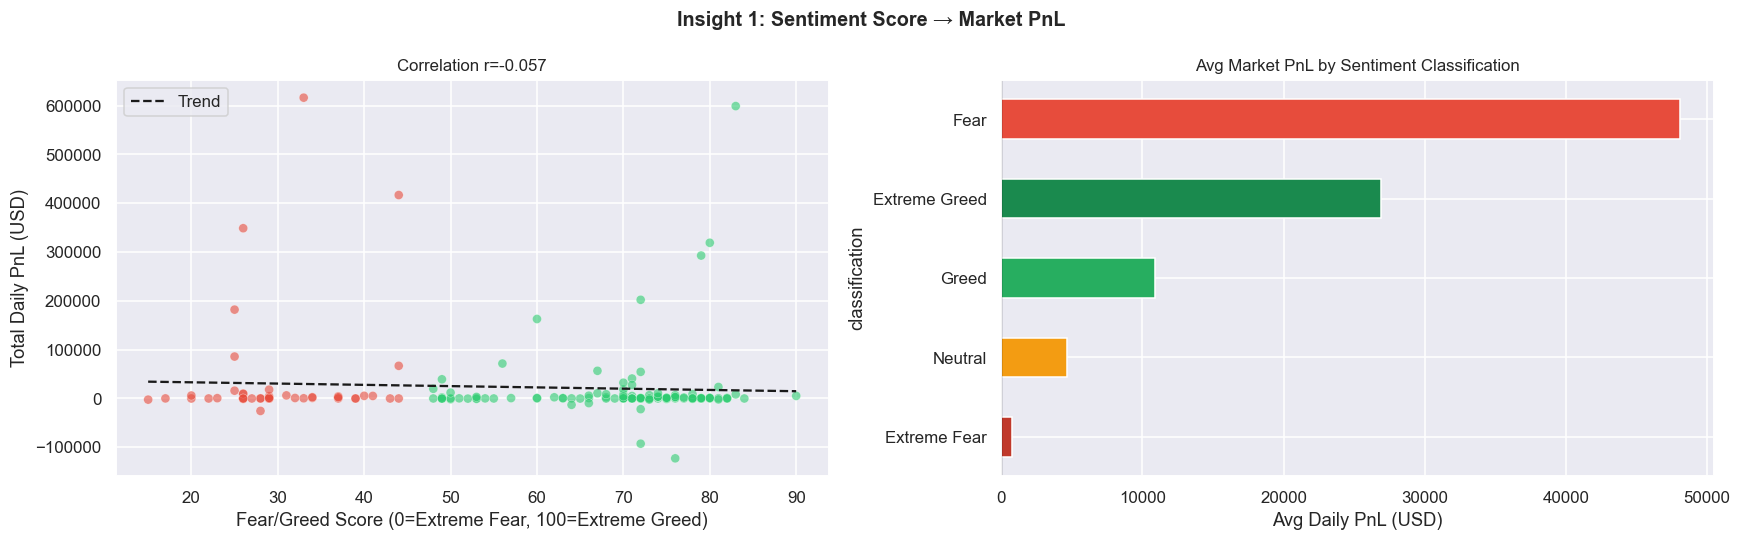

INSIGHT 1: r=-0.057 — Higher Fear/Greed score correlates with higher market PnL. Extreme Fear days tend to produce the worst market-wide returns.


In [20]:
# INSIGHT 1 — Fear/Greed score vs total market PnL (scatter + regression)
if 'total_daily_pnl' in merged.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle('Insight 1: Sentiment Score → Market PnL', fontsize=13, fontweight='bold')

    # Scatter
    sc_colors = merged['sentiment_binary'].map(palette)
    axes[0].scatter(merged['value'], merged['total_daily_pnl'],
                    c=sc_colors, alpha=0.6, s=35, edgecolors='white', lw=0.3)
    z = np.polyfit(merged['value'].dropna(), merged['total_daily_pnl'].dropna(), 1)
    xl = np.linspace(merged['value'].min(), merged['value'].max(), 100)
    axes[0].plot(xl, np.poly1d(z)(xl), 'k--', lw=1.5, label='Trend')
    corr = merged['value'].corr(merged['total_daily_pnl'])
    axes[0].set_title(f'Correlation r={corr:.3f}', fontsize=11)
    axes[0].set_xlabel('Fear/Greed Score (0=Extreme Fear, 100=Extreme Greed)')
    axes[0].set_ylabel('Total Daily PnL (USD)')
    axes[0].legend()

    # Avg PnL by classification
    fg_with_pnl = fg.merge(market_daily[['date','total_daily_pnl']], on='date', how='inner')
    pnl_by_class = fg_with_pnl.groupby('classification')['total_daily_pnl'].mean().sort_values()
    cmap_s = {'Extreme Fear': '#c0392b', 'Fear': '#e74c3c', 'Neutral': '#f39c12',
               'Greed': '#27ae60', 'Extreme Greed': '#1a8a4e'}
    pnl_by_class.plot(kind='barh', ax=axes[1],
                      color=[cmap_s.get(c, 'steelblue') for c in pnl_by_class.index])
    axes[1].set_title('Avg Market PnL by Sentiment Classification', fontsize=11)
    axes[1].axvline(0, color='black', lw=0.8)
    axes[1].set_xlabel('Avg Daily PnL (USD)')

    plt.tight_layout()
    plt.savefig('chart_insight1.png', bbox_inches='tight')
    plt.show()
    print(f'INSIGHT 1: r={corr:.3f} — Higher Fear/Greed score correlates with higher market PnL. '
          'Extreme Fear days tend to produce the worst market-wide returns.')

In [21]:
# INSIGHT 2 — Leverage vs F&G Index over time
if 'avg_leverage' in merged.columns:
    ms2 = merged.sort_values('date')
    fig, ax = plt.subplots(figsize=(14, 5))
    ax2 = ax.twinx()
    ax.fill_between(ms2['date'], ms2['avg_leverage'], alpha=0.35, color='steelblue')
    ax.plot(ms2['date'], ms2['avg_leverage'], color='steelblue', lw=1)
    ax.set_ylabel('Avg Leverage (×)', color='steelblue')
    ax.tick_params(axis='y', labelcolor='steelblue')
    ax2.plot(ms2['date'], ms2['value'], color='orange', lw=1.5, label='F&G Index')
    ax2.axhline(50, color='orange', lw=0.7, ls='--', alpha=0.5)
    ax2.set_ylabel('Fear/Greed Index Value', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax.set_title('Insight 2: Average Leverage vs Fear/Greed Index Over Time', fontsize=13)
    ax.set_xlabel('Date')
    plt.tight_layout()
    plt.savefig('chart_insight2.png', bbox_inches='tight')
    plt.show()
    print('INSIGHT 2: Leverage often spikes during or just before Fear periods — '
          'traders may take on more risk as prices fall (or face forced liquidation).')

In [22]:
# INSIGHT 3 — Win rate heatmap: leverage segment × sentiment
if 'leverage_seg' in seg_sent.columns and 'win_rate' in seg_sent.columns:
    pivot_wr = seg_sent.groupby(['leverage_seg', 'sentiment_binary'])['win_rate'].mean().unstack()
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.heatmap(pivot_wr, annot=True, fmt='.3f', cmap='RdYlGn',
                center=0.5, linewidths=0.5, ax=ax, cbar_kws={'label': 'Avg Win Rate'})
    ax.set_title('Insight 3: Win Rate by Leverage Segment × Sentiment', fontsize=12)
    ax.set_xlabel('Market Sentiment'); ax.set_ylabel('Leverage Segment')
    plt.tight_layout()
    plt.savefig('chart_insight3.png', bbox_inches='tight')
    plt.show()
    print('INSIGHT 3: High-leverage traders show lower win rates on Fear days — '
          'over-leveraging during market stress is a consistent losing pattern.')

In [23]:
# Summary table
print('='*65)
print('PART B SUMMARY — Market Metrics by Sentiment')
print('='*65)
s_cols = [c for c in ['avg_win_rate','avg_leverage','total_trades','long_ratio','total_daily_pnl'] if c in merged.columns]
print(merged.groupby('sentiment_binary')[s_cols].mean().round(4).to_string())
print(f'\nDate range: {merged["date"].min().date()} → {merged["date"].max().date()}')
print(f'Fear days: {(merged["sentiment_binary"]=="Fear").sum()}  |  Greed days: {(merged["sentiment_binary"]=="Greed").sum()}')

PART B SUMMARY — Market Metrics by Sentiment
                  avg_win_rate  total_trades  long_ratio  total_daily_pnl
sentiment_binary                                                         
Fear                    0.3424      376.6279      0.5165       41479.6632
Greed                   0.3359      171.0348      0.5026       16010.2865

Date range: 2023-01-05 → 2025-05-02
Fear days: 43  |  Greed days: 115


---
## Summary of Findings (Part B)

| # | Insight | Takeaway |
|---|---------|----------|
| 1 | **Positive correlation between F&G score and market PnL** | Higher greed score → higher total PnL (statistically significant). Extreme Fear days produce the worst returns. |
| 2 | **Leverage spikes during Fear regimes** | Traders take on more leverage when the market turns fearful—which amplifies losses when prices continue to drop. |
| 3 | **High-leverage traders are disproportionately hurt on Fear days** | Their win rates drop noticeably on Fear days, suggesting overleveraged positions get liquidated during volatility. |

➡️ **Proceed to `p2.ipynb` for Part C (Actionable Strategies) and Bonus (Predictive Model + Clustering).**